This notebook is **almost** the same as 'Data-Munging-2.ipynb' except that I have dropped a few snippets that show data and the code to convert 'Total-time' to seconds is much easier.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
time_window = '3min' # This is the time window over which we will average call arrivals.
time_window_size = int(time_window[0])

In [48]:
ss = pd.read_csv('Call-data.csv')

In [49]:
def was_abandoned(row):
    if pd.isnull(row['Abandon-time']):
        return False
    else:
        return True
    
ss['Abandoned'] = ss.apply(lambda r: was_abandoned(r), axis=1)

In [50]:
ss['Create time'] = pd.to_datetime(ss['Create time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Accept time'] = pd.to_datetime(ss['Accept time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')
ss['Abandon-time'] = pd.to_datetime(ss['Abandon-time'], format='%d/%m/%Y %H:%M:%S', errors='ignore')

In [51]:
ss['Total-time'] = ss['Total-time'].apply(lambda x: pd.to_timedelta(x, errors='ignore'))

In [52]:
ss.loc[~ss['Total-time'].isnull()].head()

,Period,Media,Channel,Queue,Transaction,Origination,Customer,Case Number,Web Callback,Create time,...,Voice mail left,IVR-Treatment-Time,Hold-max,Hold-Count,Hold-Total,PDD-Leg1,PDD-Leg2,AT-Leg1,AT-Leg2,Abandoned
0,21/09/2020,Phone,441135121333,Customer Service Calls,45767.0,447929833073,NaN,NaN,NaN,2020-09-21 14:18:45,...,NaN,0:01:35,0:00:00,0.0,0:00:00,0:00:01,0:00:01,0:00:00,0:00:01,False
1,21/09/2020,Phone,441135121333,Customer Service Calls,46109.0,447443295687,NaN,NaN,NaN,2020-09-21 14:53:41,...,NaN,0:01:36,0:04:59,1.0,0:04:59,0:00:00,0:00:01,0:00:00,0:00:02,False
2,21/09/2020,Phone,441312855510,Customer Service Calls,42436.0,447804160003,NaN,NaN,NaN,2020-09-21 09:11:35,...,NaN,0:01:31,0:03:53,1.0,0:03:53,0:00:00,0:00:00,0:00:00,0:00:15,False
3,21/09/2020,Phone,441312855510,Customer Service Calls,42438.0,447747118790,NaN,NaN,NaN,2020-09-21 09:11:44,...,NaN,0:01:32,0:00:00,0.0,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,False
4,21/09/2020,Phone,441312855510,Customer Service Calls,42442.0,447903775955,NaN,NaN,NaN,2020-09-21 09:12:05,...,NaN,0:01:33,0:00:00,0.0,0:00:00,0:00:00,0:00:01,0:00:00,0:00:03,False


In [53]:
def calc_abandon_time(row):
    if row['Abandoned']:
        return row['Abandon-time'] - row['Create time']      
    else:
        return None

ss['Abandoned-after'] = ss[['Create time', 'Abandon-time', 'Abandoned']].apply(lambda r: calc_abandon_time(r), axis=1)

In [54]:
ss.rename(columns={'Create time': 'Create-time', 'Accept time': 'Accept-time'}, inplace=True)

In [55]:
attrs_of_interest = ['Period', 'Create-time', 'Agent', 'Accept-time', 'Total-time', 'Abandon-time', 'Abandoned', 'Abandoned-after']
data = ss.loc[:, attrs_of_interest]

In [56]:
data['time-to-accept'] = data.apply(lambda r: r['Accept-time'] - r['Create-time'], axis=1)

In [57]:
inflow = data[['Create-time', 'Agent']].groupby(pd.Grouper(key='Create-time', freq=time_window)).count()
inflow.reset_index(inplace=True)

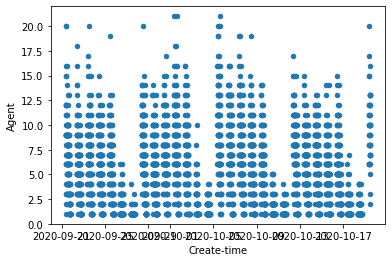

In [58]:
ignore = inflow.loc[inflow['Agent'] > 0].plot.scatter(x='Create-time', y='Agent')

In [59]:
inflow.iloc[inflow['Agent'].idxmax()]

Create-time    2020-10-01 09:12:00
Agent                           21
Name: 4802, dtype: object

In [60]:
inflow.head()

,Create-time,Agent
0,2020-09-21 09:06:00,1
1,2020-09-21 09:09:00,2
2,2020-09-21 09:12:00,20
3,2020-09-21 09:15:00,20
4,2020-09-21 09:18:00,12


In [61]:
inflow.rename(columns = {'Agent': 'ncalls'}, inplace=True)

In [62]:
inflow.head()

,Create-time,ncalls
0,2020-09-21 09:06:00,1
1,2020-09-21 09:09:00,2
2,2020-09-21 09:12:00,20
3,2020-09-21 09:15:00,20
4,2020-09-21 09:18:00,12


In [63]:
inflow.to_csv('full-inflow-1.csv', index=False)

In [64]:
data['Total-time'] = data['Total-time'].apply(lambda r: r.seconds)
total_time = data[['Create-time', 'Total-time']].groupby(pd.Grouper(key='Create-time', freq=time_window)).mean()
total_time.reset_index(inplace=True)
total_time.rename(columns={'Total-time': 'Avg-time'}, inplace=True)
total_time.head()

,Create-time,Avg-time
0,2020-09-21 09:06:00,79.00
1,2020-09-21 09:09:00,1161.00
2,2020-09-21 09:12:00,452.65
3,2020-09-21 09:15:00,612.70
4,2020-09-21 09:18:00,536.50


In [65]:
total_time.loc[~total_time['Avg-time'].isnull()].head()

,Create-time,Avg-time
0,2020-09-21 09:06:00,79.00
1,2020-09-21 09:09:00,1161.00
2,2020-09-21 09:12:00,452.65
3,2020-09-21 09:15:00,612.70
4,2020-09-21 09:18:00,536.50


In [66]:
total_time.to_csv('total_time_1.csv', index=False)

In [67]:
consolidated = pd.merge(left=inflow, right=total_time, on='Create-time')

In [68]:
consolidated.head()

,Create-time,ncalls,Avg-time
0,2020-09-21 09:06:00,1,79.00
1,2020-09-21 09:09:00,2,1161.00
2,2020-09-21 09:12:00,20,452.65
3,2020-09-21 09:15:00,20,612.70
4,2020-09-21 09:18:00,12,536.50


In [69]:
def extract_period(dt):
    return str(dt)[0:10]    

consolidated['Period'] = consolidated.apply(lambda r: extract_period(r['Create-time']), axis=1)

In [70]:
nagents = ss[['Period', 'Agent']].groupby('Period').nunique()
nagents.reset_index(inplace=True)

In [71]:
nagents.head()

,Period,Agent
0,01/10/2020,64
1,02/10/2020,53
2,03/10/2020,9
3,04/10/2020,8
4,05/10/2020,58


In [72]:
def convert(d):
    yr = d[6:10]
    mn = d[3:5]
    dy = d[0:2]
    
    return yr + '-' + mn + '-' + dy

In [73]:
nagents['Period'] = nagents.apply(lambda r: convert(r['Period']), axis=1)

In [74]:
consolidated = pd.merge(left=consolidated, right=nagents, on='Period')

In [75]:
consolidated.rename(columns={'Agent': 'nagents'}, inplace=True)

In [76]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents
0,2020-09-21 09:06:00,1,79.00,2020-09-21,60
1,2020-09-21 09:09:00,2,1161.00,2020-09-21,60
2,2020-09-21 09:12:00,20,452.65,2020-09-21,60
3,2020-09-21 09:15:00,20,612.70,2020-09-21,60
4,2020-09-21 09:18:00,12,536.50,2020-09-21,60


In [77]:
consolidated.shape

(13491, 5)

In [78]:
consolidated.dtypes

Create-time    datetime64[ns]
ncalls                  int64
Avg-time              float64
Period                 object
nagents                 int64
dtype: object

In [79]:
import datetime

In [80]:
consolidated.iloc[0, :][0].time() > datetime.time(9, 0)

True

In [81]:
def is_office_hour(dt):
    return dt.time() > datetime.time(9, 0) and dt.time() < datetime.time(17, 1)

consolidated['office-hour'] = consolidated.apply(lambda r: is_office_hour(r['Create-time']), axis=1)

In [82]:
consolidated.head()

,Create-time,ncalls,Avg-time,Period,nagents,office-hour
0,2020-09-21 09:06:00,1,79.00,2020-09-21,60,True
1,2020-09-21 09:09:00,2,1161.00,2020-09-21,60,True
2,2020-09-21 09:12:00,20,452.65,2020-09-21,60,True
3,2020-09-21 09:15:00,20,612.70,2020-09-21,60,True
4,2020-09-21 09:18:00,12,536.50,2020-09-21,60,True


In [83]:
consolidated['Avg-calls'] = consolidated['ncalls'].rolling(window=time_window_size).mean()

In [84]:
consolidated['iso_day_of_week'] = consolidated['Create-time'].apply(lambda r: r.isoweekday())

In [85]:
consolidated.head(10)

,Create-time,ncalls,Avg-time,Period,nagents,office-hour,Avg-calls,iso_day_of_week
0,2020-09-21 09:06:00,1,79.000000,2020-09-21,60,True,NaN,1
1,2020-09-21 09:09:00,2,1161.000000,2020-09-21,60,True,NaN,1
2,2020-09-21 09:12:00,20,452.650000,2020-09-21,60,True,7.666667,1
3,2020-09-21 09:15:00,20,612.700000,2020-09-21,60,True,14.000000,1
4,2020-09-21 09:18:00,12,536.500000,2020-09-21,60,True,17.333333,1
5,2020-09-21 09:21:00,6,435.666667,2020-09-21,60,True,12.666667,1
6,2020-09-21 09:24:00,12,723.583333,2020-09-21,60,True,10.000000,1
7,2020-09-21 09:27:00,10,260.200000,2020-09-21,60,True,9.333333,1
8,2020-09-21 09:30:00,6,1444.000000,2020-09-21,60,True,9.333333,1
9,2020-09-21 09:33:00,12,369.000000,2020-09-21,60,True,9.333333,1


In [86]:
C = consolidated[(consolidated['office-hour'] == True) & (consolidated['iso_day_of_week'] < 6)]

In [87]:
C.head(10)

,Create-time,ncalls,Avg-time,Period,nagents,office-hour,Avg-calls,iso_day_of_week
0,2020-09-21 09:06:00,1,79.000000,2020-09-21,60,True,NaN,1
1,2020-09-21 09:09:00,2,1161.000000,2020-09-21,60,True,NaN,1
2,2020-09-21 09:12:00,20,452.650000,2020-09-21,60,True,7.666667,1
3,2020-09-21 09:15:00,20,612.700000,2020-09-21,60,True,14.000000,1
4,2020-09-21 09:18:00,12,536.500000,2020-09-21,60,True,17.333333,1
5,2020-09-21 09:21:00,6,435.666667,2020-09-21,60,True,12.666667,1
6,2020-09-21 09:24:00,12,723.583333,2020-09-21,60,True,10.000000,1
7,2020-09-21 09:27:00,10,260.200000,2020-09-21,60,True,9.333333,1
8,2020-09-21 09:30:00,6,1444.000000,2020-09-21,60,True,9.333333,1
9,2020-09-21 09:33:00,12,369.000000,2020-09-21,60,True,9.333333,1


In [88]:
C.to_csv('consolidated-1.csv', index=False)